# TaP Analysis

TaP proved to be a very stubborn substance for matching with experimental EFG data, across various DFT methods. In WIEN2k, it never seemed to converge with respect to `RKMAX` and spin-orbit coupling had no appreciable effect. The $ V_{zz} $ component always agreed well with experiment and FPLO, but the asymmetry was always off. FPLO, although claimed by the authors that it agreed well, still had an appreciable error, although it produced good NQR frequencies compared to the measurements. Using a `pv` potential on the tantalum site gave even more outrages results and bizarre asymmetry, however the `sv` potential nailed experimental values, outperforming both WIEN2k and FPLO.

In [1]:
# Load "autoreload" extension so that code can change; set it so modules are reloaded before execution
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.constants import e, h, mega
from wien2k.core import Wien2kParse
from nqr.core import Efg
import os
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
%matplotlib inline

In [3]:
# Function for extracting data and making plots
def make_plots(w2k, val_type, conv_types, conv_dirs, tols, dpi=125):
    efg_units = ' (V/m$^2)$'
    data_dict = {'Vxx': [], 'Vyy': [], 'Vzz': [], 'eta': []}
    ylabels = {'Vxx': '$V_{xx}$', 'Vyy': '$V_{yy}$', 'Vzz': '$V_{zz}$', 'eta': '$\eta$'}
    fig, axs = plt.subplots(len(conv_types), dpi=dpi)
    for i, conv_type in enumerate(conv_types):
        ax = axs[i]
        X, data_dict['Vxx'], data_dict['Vyy'], data_dict['Vzz'], data_dict['eta'] = w2k.efg_conv_data(site, conv_type, conv_dir=conv_dirs[i])
        data = data_dict[val_type]
        conv = w2k.check_conv(X, data, tols[i])
        ax.plot(X, data, '.-')
        ax.set(xlabel=conv_type, ylabel=ylabels[val_type])
    fig.tight_layout()
    
    return data_dict['Vzz'], data_dict['eta']

In [4]:
mat = 'TaP'
site = 'Ta1'
raw_data_path = op.abspath(f'../../data/raw/{mat}/{mat}')
w2k = Wien2kParse(raw_data_path)
conv_types = ['kpoints', 'rkmax']
conv_dirs = ['kpoints', 'rkmax']
conv_tols = [1e-3, 1e-3]

## Check WIEN2k convergence with respect to $ V_{xx} $, $ V_{yy} $, and $ V_{zz} $.

Kpoints is varied until convergence. `Rkmax` is varied with `gmax = 1.7*rkmax`.

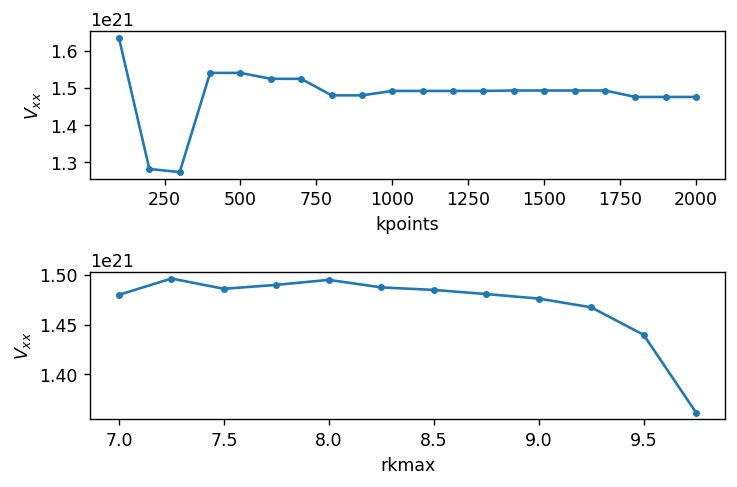

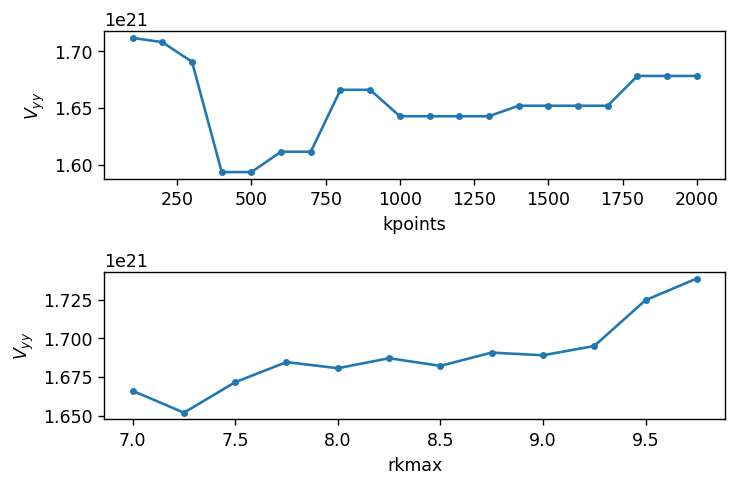

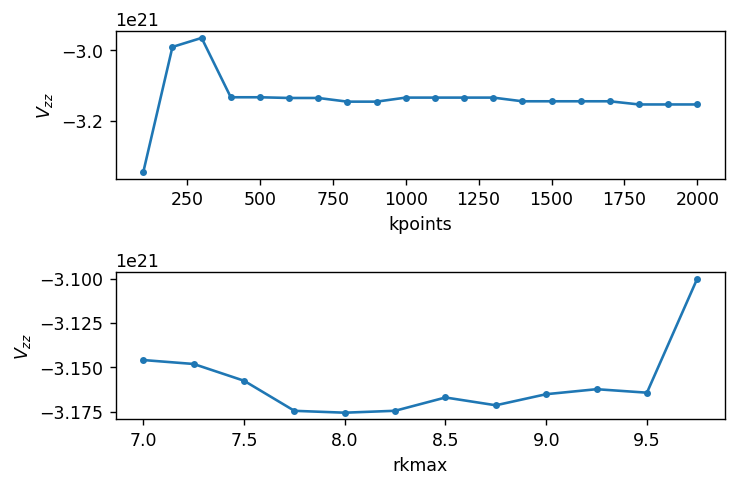

In [5]:
make_plots(w2k, 'Vxx', conv_types=conv_types, conv_dirs=conv_dirs, tols=1e21*np.array([1e-2, 1e-2]))
make_plots(w2k, 'Vyy', conv_types=conv_types, conv_dirs=conv_dirs, tols=1e21*np.array([1e-2, 1e-2]))
make_plots(w2k, 'Vzz', conv_types=conv_types, conv_dirs=conv_dirs, tols=1e21*np.array([1e-2, 1e-2]));

## Compare with other DFT methods and experiment
Choose with `kpoints=1500`, `rkmax=9.5`,  and `gmax=16.15`. VASP values in the table below are from the `sv` PAW potentials for tantalum.

In [6]:
Q = 3.71e-28
I = 7/2
efg = {}
nuQ = {}
# efg['vasp'] = 1e20*Efg(mat, site, V=[2.081, 20.328, -22.409]) # T_pv potentials used
efg['vasp'] = 1e20*Efg(mat, site, V=[8.878, 21.595, -30.472]) # T_sv potentials used
efg['exp'] = -1e21*Efg(mat, site, V=[-0.865, -2.139, 3.004])
efg['wien'] = w2k.efg['Ta1']
w2k.kpoints, w2k.rkmax, w2k.gmax, w2k.efg[site]
err = np.abs((np.abs(efg['exp'].V) - np.abs(efg['wien'].V))/efg['exp'].V)
nuQ['wien'] = (3*e*efg['wien'].Vzz*Q)/(2*I*(2*I-1)*h)
nuQ['exp'] = (3*e*efg['exp'].Vzz*Q)/(2*I*(2*I-1)*h)
nuQ['vasp'] = (3*e*efg['vasp'].Vzz*Q)/(2*I*(2*I-1)*h)
d = {'units': [*('1e21 V/m^2',)*3], 'vasp': efg['vasp'].V/1e21, 'wien2k': efg['wien'].V/1e21, 'exp': efg['exp'].V/1e21}
df = pd.DataFrame(data=d)
df['wien_abs_err'] = np.abs((np.abs(df.exp) - np.abs(df.wien2k))/df.exp)
df['vasp_abs_err'] = np.abs((np.abs(df.exp) - np.abs(df.vasp))/df.exp)
df.index = ['Vxx', 'Vyy', 'Vzz']
df.style.set_table_attributes('style="font-size: 16px"')